## En este documento se muestra el procedimiento para hacer escalado de las imagenes y los bounding box (bbox) simultaneamente, a partir de un archivo contenedor de los bbbox y la ruta a la carpeta contenedora de las imagenes en cuestion. Nota esta ajustado para formato COCO.

In [2]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

### En versiones previas de albumentation no existe el BboxParams, se recomienda usar la actual.

In [5]:
A.__version__, cv2.__version__

('0.5.0', '4.4.0')

In [9]:
cd ..

/home/victor/Escritorio/labels_my-project-name_2020-10-19-05-07-12


In [ ]:
ruta_imagen = "gen_box/"  # carpeta que contiene las imagenes originales
rutas_enteras = [ruta_imagen+x for x in os.listdir(ruta_imagen)]
etiquetas = pd.read_csv("bb_gen_box.csv")  # Archivo que contiene los bounding box
ruta_salida = "gen_box_resized/"  # Carpeta donde se desea almacenar las imagenes nuevas

In [27]:
lista_archivos = etiquetas.file.unique()

## se verifica que haya etiquetas para todas las imagenes

In [29]:
faltantes = []
for x in os.listdir(ruta_imagen):
    if x not in lista_archivos:
        faltantes.append(x)
len(faltantes), faltantes

(0, [])

In [30]:
def resize(df_original: pd.DataFrame, ruta_imagen: str, ruta_salida: str, size_final: tuple=(224, 224)) -> list:
    """
    :param df_original: pandas DataFrame que contiene las etiquetas en formato COCO
    :param ruta_imagen: str path a la carpeta contenedora de las imagenes originales
    :param ruta salida: str path a la carpeta de destino de las imagenes modificadas
    :size_final: tuple indicando el tamaño final deseado
    :return: list contiene los nuevos bounding box de las imagenes que fueron modificadas 
                  y almacenadas en la carpeta destino  
    """
    bbox = []
    categorie_ids = [1]
    transform = A.Compose([A.Resize(size_final[0], size_final[1], p=1)], 
                          bbox_params=A.BboxParams(format='coco', 
                                                   label_fields=['category_ids']))
    for X in os.listdir(ruta_imagen):
        labels = df_original.loc[df_original.file == X]
        x, y = int(labels.x.values[0])+1, int(labels.y.values[0])+1
        w, h = int(labels.w.values[0])+1, int(labels.h.values[0])+1
        img = cv2.imread(ruta_imagen+X)
        img_red = transform(image=img, bboxes=[[x, y, w, h]], category_ids=categorie_ids)
        cv2.imwrite(ruta_salida+X, img_red['image'])
        x, y, w, h = img_red['bboxes'][0]
        row = [X, int(x)+1, int(y)+1, int(w)+1, int(h)+1]
        bbox.append(row)
    return bbox        

In [31]:
bbox = resize(etiquetas, ruta_imagen, ruta_salida)

In [32]:
# se crea y almacena el nuevo archivo con los bounding box editados
df_nuevo = pd.DataFrame(data=bbox, columns=['file', 'x', 'y', 'w', 'h'])
df_nuevo.to_csv("bbox_resized/bb_gen_box_resized.csv")

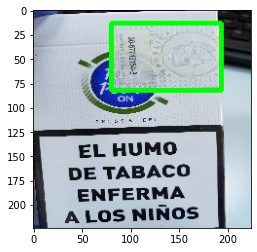

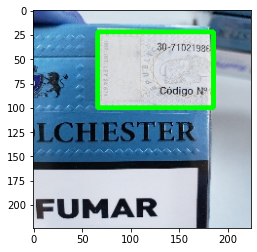

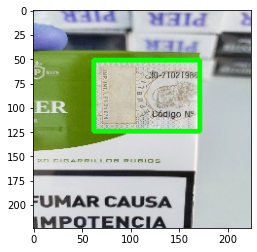

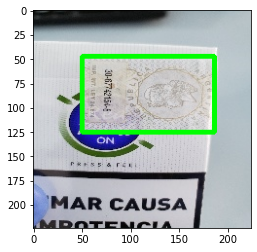

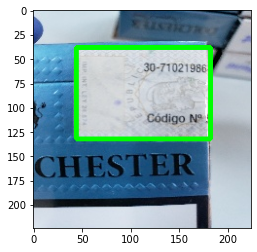

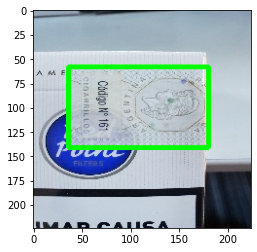

In [34]:
n = 0
for x in os.listdir(ruta_salida):
    i = cv2.imread(ruta_salida+x)
    labels = df_nuevo.loc[df_nuevo.file == x]
    r = [labels.x, labels.y, labels.w, labels.h]
    i = cv2.rectangle(img=i, pt1=(int(r[0]), int(r[1])), pt2=(int(r[0]+r[2]), int(r[1]+r[3])), 
                      color=(0, 255, 0), thickness=3)
    plt.imshow(i)
    plt.show()
    n += 1
    if n > 5:
        break

In [11]:
# Creado por Victor Vivas.